# Triplet Loss on Face Recognition Project

In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

The file: triplet.csv contains triplet of images. The triplet file contains three images. To prepare the project and train the model, I initially use only part of the available data.

In [2]:
triplets_df = pd.read_csv("triplets.csv")

# I only use part of the downloaded dataset
part = 0.2 
triplets_df = triplets_df.sample(frac=part, random_state=42).reset_index(drop=True)

images_folder = "images"

In [3]:
triplets_df.head(5)

,anchor,id1,pos,id2,neg,id3
0,044895.jpg,8827,043201.jpg,8827,067806.jpg,7899
1,089730.jpg,8178,034159.jpg,8178,112980.jpg,4732
2,069225.jpg,9506,038812.jpg,9506,002820.jpg,4833
3,113688.jpg,976,042239.jpg,976,123909.jpg,6909
4,197395.jpg,6135,196600.jpg,6135,046217.jpg,1759


### Image transformation

In [4]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # (-1 - 1)
])

To load three images I use a prepared data frame (from triplets.csv )

In [5]:
class TripletDataset(Dataset):
    def __init__(self, triplets_df, images_folder, transform=None):
        self.triplets_df = triplets_df
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.triplets_df)

    def __getitem__(self, idx):
        
        row = self.triplets_df.iloc[idx]
        
        anchor_path = os.path.join(self.images_folder, row['anchor'])
        pos_path = os.path.join(self.images_folder, row['pos'])
        neg_path = os.path.join(self.images_folder, row['neg'])
        
        anchor_img = Image.open(anchor_path).convert("RGB")
        pos_img = Image.open(pos_path).convert("RGB")
        neg_img = Image.open(neg_path).convert("RGB")
        
        #IMAGE TRANSFORMATION
        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anchor_img, pos_img, neg_img

### Model hyperparameters

In [11]:
batch_size = 32
learning_rate = 0.0001
margin_triplet_loss = 1.0
num_epochs = 15

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA LOADING

In [13]:
triplet_dataset = TripletDataset(triplets_df, images_folder, transform=transform)
triplet_loader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True)

# CNN 
The FaceEmbeddingCNN model consists of 4 convolutional layers that extract features from the input face image. Pooling oparations reduces the image size. 

I use Global Average Pooling to simplify the structure. 
The fully connected layer transform the vector into the output face embedding (size 128).

In [14]:
class FaceEmbeddingCNN(nn.Module):
    def __init__(self, embedding_size=128):
        super(FaceEmbeddingCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  #reducing image size


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        #Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(256, embedding_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        embedding = self.fc1(x)

        # L2 NORMALIZATION
        embedding = F.normalize(embedding, p=2, dim=1)
        
        return embedding

In [15]:
model = FaceEmbeddingCNN()
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epoch_losses = [] 
iteration_losses = []  

## TRAINING LOOP

In [17]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (anchor, pos, neg) in enumerate(triplet_loader):
        print(i)
        optimizer.zero_grad()
        
        anchor = anchor.to(device)
        pos = pos.to(device)
        neg = neg.to(device)
        
        anchor_embedding = model(anchor)
        pos_embedding = model(pos)
        neg_embedding = model(neg)
        
        # backpropagation
        loss = triplet_loss_fn(anchor_embedding, pos_embedding, neg_embedding)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        iteration_losses.append(loss.item())
        
        if i % 10 == 0: 
            print(f"Epoch: [{epoch + 1}/{num_epochs}], Iteration [{i}/{len(triplet_loader)}], Loss: {loss.item():.4f}")
            print(f"Image Index: {i * batch_size} - {(i + 1) * batch_size - 1}")
    
    # Average Loss for the Epoch
    avg_epoch_loss = total_loss / len(triplet_loader)
    epoch_losses.append(avg_epoch_loss)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}")

0
Epoch: [1/15], Iteration [0/103], Loss: 0.9852
Image Index: 0 - 31
1
2
3
4
5
6
7
8
9
10
Epoch: [1/15], Iteration [10/103], Loss: 0.7182
Image Index: 320 - 351
11
12
13
14
15
16
17
18
19
20
Epoch: [1/15], Iteration [20/103], Loss: 0.7722
Image Index: 640 - 671
21
22
23
24
25
26
27
28
29
30
Epoch: [1/15], Iteration [30/103], Loss: 0.7945
Image Index: 960 - 991
31
32
33
34
35
36
37
38
39
40
Epoch: [1/15], Iteration [40/103], Loss: 0.8830
Image Index: 1280 - 1311
41
42
43
44
45
46
47
48
49
50
Epoch: [1/15], Iteration [50/103], Loss: 0.8041
Image Index: 1600 - 1631
51
52
53
54
55
56
57
58
59
60
Epoch: [1/15], Iteration [60/103], Loss: 0.8859
Image Index: 1920 - 1951
61
62
63
64
65
66
67
68
69
70
Epoch: [1/15], Iteration [70/103], Loss: 0.8110
Image Index: 2240 - 2271
71
72
73
74
75
76
77
78
79
80
Epoch: [1/15], Iteration [80/103], Loss: 0.7095
Image Index: 2560 - 2591
81
82
83
84
85
86
87
88
89
90
Epoch: [1/15], Iteration [90/103], Loss: 0.8267
Image Index: 2880 - 2911
91
92
93
94
95
96
9

## Visualization of the change in the average Triplet Loss value for epochs and iterations

More important is the visualization of the average loss value for the epochs.

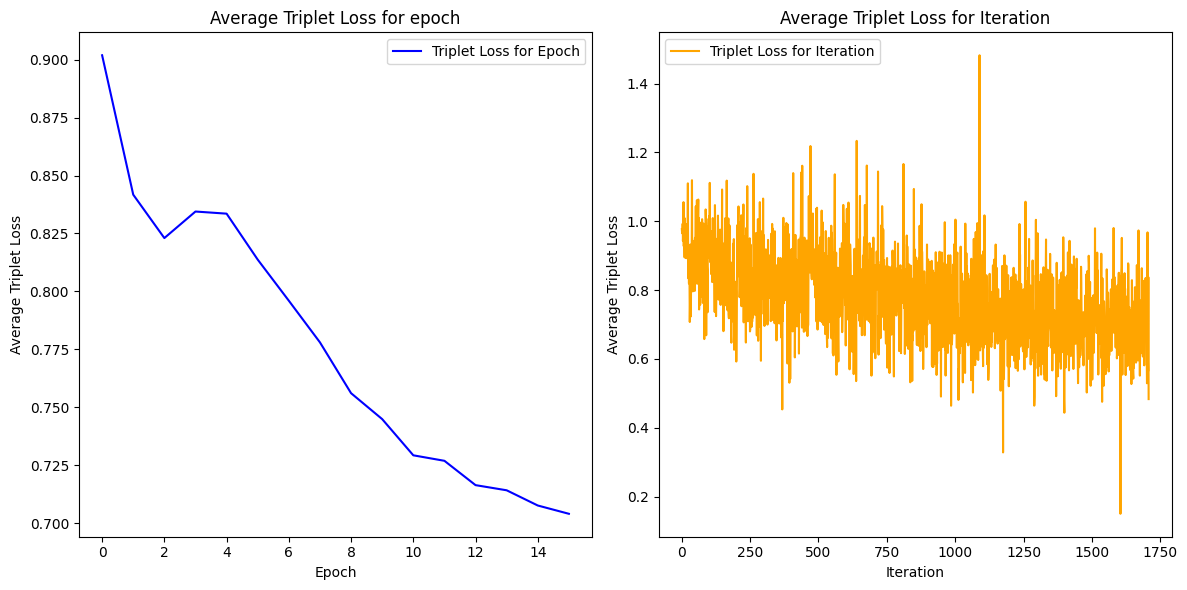

In [21]:
plt.figure(figsize=(12, 6))

# Average Loss for Epochs
plt.subplot(1, 2, 1)
plt.plot(range(0, num_epochs+1), epoch_losses, label='Triplet Loss for Epoch', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Average Triplet Loss')
plt.title('Average Triplet Loss for epoch')
plt.legend()

# Average Loss for Iterations
plt.subplot(1, 2, 2)
plt.plot(range(1, len(iteration_losses)+1), iteration_losses, label='Triplet Loss for Iteration', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Average Triplet Loss')
plt.title('Average Triplet Loss for Iteration')
plt.legend()

plt.tight_layout()
plt.show()

### Saving the model to a pth file

In [23]:
torch.save(model.state_dict(), "trained_model.pth")
print("The model is saved to 'trained_model.pth' file.")

The model is saved to 'trained_model.pth' file.
